In [4]:
%load_ext autoreload
%autoreload 2

import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

import os

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch
torch.set_default_tensor_type(torch.DoubleTensor)

import renyi
import utils
import sxp

from time import time

In [5]:
os.makedirs('./data/mnist', exist_ok=True)

mnist = torch.utils.data.DataLoader(torchvision.datasets.MNIST('./data/mnist', train=True, download=True,))

letters = torch.utils.data.DataLoader(torchvision.datasets.EMNIST('./data/emnist', 'letters', train=True, download=True,))

fashion = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST('./data/fashion', train=True, download=True))

In [76]:
def img_mixture_mink_divergence(p, q, alpha, kernel):   
    
    iKp = kernel(p)
    iKq = kernel(q)
    diff = torch.abs(iKp - iKq) ** alpha
    div =  (p * diff).sum(dim=1).sum(dim=1) ** (1 / alpha)
    return div

In [71]:
img_mixture_mink_divergence(nu, mu, alpha, kernel=img_kernel).mean()

tensor(nan, grad_fn=<MeanBackward1>)

In [7]:
def img_mixture_divergence(mu, nu, alpha, kernel, img_shape=None, use_avg=True):   
    
    Kmu = kernel(mu)
    Knu = kernel(nu)

    if use_avg:
        r = (mu + nu) / 2
        Kr = kernel(r)
        rat1 = Kmu / utils.min_clamp(Kr)
        rat2 = Knu / utils.min_clamp(Kr)
    else:
        rat1 = Kmu / utils.min_clamp(Knu)
        rat2 = Knu / utils.min_clamp(Kmu)
    
    rat1 = utils.min_clamp(rat1)
    rat2 = utils.min_clamp(rat2)
    
    if alpha == 1:
        u = (mu * torch.log(rat1)).sum(dim=-1).sum(dim=-1)
        v = (nu * torch.log(rat2)).sum(dim=-1).sum(dim=-1)

        return (u + v)
    else:
        
        u = (mu * rat1**(alpha-1)).sum(dim=-1).sum(dim=-1)
        u = torch.log(utils.min_clamp(u))

        v = (nu * rat2**(alpha-1)).sum(dim=-1).sum(dim=-1)
        v = torch.log(utils.min_clamp(v))

        return (u + v) / (alpha - 1)

def sample_and_resize(D, img_size, num_samples=1):
    res = []
    for _ in range(num_samples):
        ix = int(np.random.choice(len(D), 1))
        sample_img = D[ix, ...].data.numpy()
        #sample_img = tform(sample_img)[0, ...].data.numpy()
        if img_size != 28:
            sample_img = resize(sample_img, (img_size, img_size), mode='constant')
        sample_img = np.abs(sample_img) / np.abs(sample_img).sum()
        res.append(sample_img)
    return torch.tensor(res).double()

In [87]:
from skimage.transform import resize

img_size = 28#50
# Z = torch.tensor(np.array(list(itertools.product(np.linspace(0, 1, img_size), np.linspace(0, 1, img_size))))).double()
# K = rbf_kernel(torch.cat((Z, Z)),  [0.1], 2).double()
# old_kernel = lambda x: K

[Ygrid, Xgrid] = np.meshgrid(np.linspace(0, 1, img_size), np.linspace(0, 1, img_size))
Kmat = np.exp(-np.abs(Xgrid - Ygrid)**2/(0.01**2))
#Kmat = 1 / (1 + np.abs(Xgrid - Ygrid)**0.01)
Kmat = torch.tensor(Kmat)

img_kernel = lambda x: torch.matmul(torch.matmul(Kmat, x), Kmat)

#plt.imshow(img_kernel(utils.draw_circle(img_size)))

tform = torchvision.transforms.Compose(
                      [torchvision.transforms.ToPILImage(),
                       torchvision.transforms.RandomAffine(10, translate=(0., 0.), scale=(0.5, 1), shear=0, resample=False, fillcolor=0),
                       torchvision.transforms.ToTensor()
                      ])

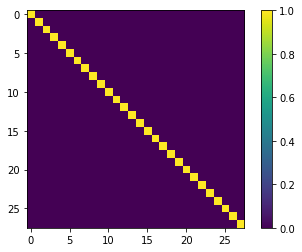

In [88]:
plt.imshow(Kmat)
plt.colorbar()

In [102]:
alpha = 1

barys = []

data = mnist

for digit in range(0, 10):
    start = time()
    ix = data.dataset.train_labels == digit
    D = data.dataset.train_data[ix].view(-1, 28, 28).float()
    
    # for EMNIST
    #D = data.dataset.train_data[ix].view(-1, 28, 28).transpose(-1, -2).float()
    
    logit_mu = torch.nn.Parameter(torch.rand(1, img_size*img_size))
    temp = torch.nn.Parameter(torch.tensor(1.))

    optimizer = torch.optim.Adam([logit_mu, temp], lr=0.05, amsgrad=True)
    #optimizer = torch.optim.RMSprop([logit_mu, temp], lr=0.05)
    
    for i in range(250):

        optimizer.zero_grad()
        
        mu = torch.softmax(logit_mu /  torch.exp(temp), dim=1).view(1, img_size, img_size) 
        nu = sample_and_resize(D[0:-1, ...], img_size, 32)
        
        l3 = img_mixture_mink_divergence(nu, mu, alpha, kernel=img_kernel).mean()
        #l3 = l3 + img_mixture_mink_divergence(mu, nu, alpha, kernel=img_kernel).mean()
        
#         l1 = img_mixture_divergence(nu, nu, alpha, kernel=img_kernel, use_avg=True).mean()
#         l2 = img_mixture_divergence(mu, mu, alpha, kernel=img_kernel, use_avg=True).mean()
#         l3 = img_mixture_divergence(nu, mu, alpha, kernel=img_kernel, use_avg=True).mean()
        loss = l3 #- l1 - l2 
        
        if i % 50 == 0:
            print("%d - %d - %.4f" % (digit, i, loss.item()))

        if False and i % 200 == 0:
            mu = torch.softmax(logit_mu, dim=1).view(img_size, img_size).data
            plt.figure(figsize=(2, 2))
            plt.imshow(mu, cmap='hot_r');
            plt.show()

        loss.backward()
        optimizer.step()
    
    mu = torch.softmax(logit_mu /  torch.exp(temp), dim=1).view(img_size, img_size)
    barys.append(mu.data)
    
    print('Class time: ', time()-start)

0 - 0 - 0.0052
0 - 50 - 0.0032
0 - 100 - 0.0030
0 - 150 - 0.0028
0 - 200 - 0.0035
Class time:  2.8203608989715576
1 - 0 - 0.0151
1 - 50 - 0.0075
1 - 100 - 0.0077
1 - 150 - 0.0075
1 - 200 - 0.0067
Class time:  2.814506769180298
2 - 0 - 0.0071
2 - 50 - 0.0040
2 - 100 - 0.0038
2 - 150 - 0.0043
2 - 200 - 0.0041
Class time:  2.896674156188965
3 - 0 - 0.0066
3 - 50 - 0.0040
3 - 100 - 0.0038
3 - 150 - 0.0041
3 - 200 - 0.0034
Class time:  2.8229384422302246
4 - 0 - 0.0094
4 - 50 - 0.0046
4 - 100 - 0.0055
4 - 150 - 0.0044
4 - 200 - 0.0044
Class time:  2.787363052368164
5 - 0 - 0.0077
5 - 50 - 0.0047
5 - 100 - 0.0044
5 - 150 - 0.0051
5 - 200 - 0.0046
Class time:  2.804138660430908
6 - 0 - 0.0072
6 - 50 - 0.0040
6 - 100 - 0.0047
6 - 150 - 0.0035
6 - 200 - 0.0037
Class time:  2.788038730621338
7 - 0 - 0.0091
7 - 50 - 0.0048
7 - 100 - 0.0049
7 - 150 - 0.0056
7 - 200 - 0.0044
Class time:  2.765273094177246
8 - 0 - 0.0064
8 - 50 - 0.0040
8 - 100 - 0.0039
8 - 150 - 0.0039
8 - 200 - 0.0037
Class time: 

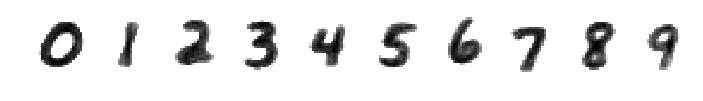

In [104]:
plt.figure(figsize=(1.2*len(barys), 3))
cat_barys = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in barys], dim=1)
plt.imshow(cat_barys, cmap='gray_r')
plt.axis('off')
plt.show()

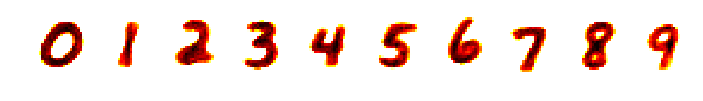

In [103]:
plt.figure(figsize=(1.2*len(barys), 3))
cat_barys = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in barys], dim=1)
plt.imshow(cat_barys, cmap='hot_r')
plt.axis('off')
plt.show()

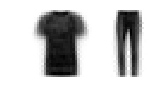

In [51]:
plt.figure(figsize=(1.2*len(barys), 3))
cat_barys = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in barys], dim=1)
plt.imshow(cat_barys, cmap='gray_r')
plt.axis('off')
plt.show()

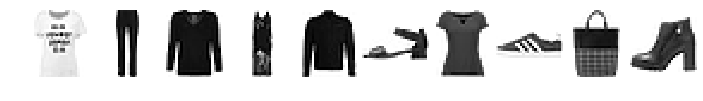

In [690]:
toshow = []
for digit in range(0, 10):
    ix = data.dataset.train_labels == digit
    D = data.dataset.train_data[ix].view(-1, 28, 28).float()
    toshow.append(D[np.random.choice(D.shape[0])])
    
plt.figure(figsize=(12, 2))
#toshow = D[np.random.choice(D.shape[0])] / D[np.random.choice(D.shape[0])].sum() 
plt.imshow(torch.cat(toshow, dim=1).data.numpy(), cmap='gray_r')
plt.axis('off')
plt.show()